In [13]:
import boto3
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import RandomCutForest

bucket = 'anomaly-detection-team-vypin'   # <--- specify a bucket you have access to
prefix = 'vishal/sagemaker/rcf-benchmarks'


s3_training_data_location='s3://anomaly-detection-team-vypin/vishal/train.csv'
cleaned_data=pd.read_csv(s3_training_data_location)
cleaned_data.shape

(4453833, 11)

In [14]:
session=sagemaker.Session()
execution_role = get_execution_role()

train_data = sagemaker.s3_input(
       s3_data=s3_training_data_location,
       content_type='text/csv;label_size=0',
       distribution='ShardedByS3Key')

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      base_job_name='vishal',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

rcf.fit(rcf.record_set(cleaned_data.as_matrix()))
#rcf.fit({'train': train_data})

INFO:sagemaker:Creating training-job with name: vishal-2019-03-07-18-30-38-812


2019-03-07 18:30:38 Starting - Starting the training job...
2019-03-07 18:30:39 Starting - Launching requested ML instances............
2019-03-07 18:32:44 Starting - Preparing the instances for training......
2019-03-07 18:34:09 Downloading - Downloading input data.....
Docker entrypoint called with argument(s): train
[03/07/2019 18:34:53 INFO 140140272490304] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/07/2019 18:34:53 INFO 140140272490304] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'11', u'num_samples_


2019-03-07 18:35:07 Training - Training image download completed. Training in progress.
2019-03-07 18:35:07 Uploading - Uploading generated training model[2019-03-07 18:35:02.599] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 8122, "num_examples": 4454, "num_bytes": 498829296}
[03/07/2019 18:35:02 INFO 140140272490304] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 8135.572910308838, "sum": 8135.572910308838, "min": 8135.572910308838}}, "EndTime": 1551983702.612691, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1551983694.463302}

[03/07/2019 18:35:02 INFO 140140272490304] Early stop condition met. Stopping training.
[03/07/2019 18:35:02 INFO 140140272490304] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count"

In [15]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

print('Endpoint name: {}'.format(rcf_inference.endpoint))

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-18-35-52-893
INFO:sagemaker:Creating endpoint with name vishal-2019-03-07-18-30-38-812


----------------------------------------------------------------------------!Endpoint name: vishal-2019-03-07-18-30-38-812


In [16]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

cleaned_data_numpy = cleaned_data.as_matrix()
print(cleaned_data_numpy[:6])


[[5.22000000e+02 4.06348000e+03 2.01730000e+04 1.61095200e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [2.75000000e+02 9.83906350e+05 0.00000000e+00 0.00000000e+00
  1.00395351e+06 1.98785986e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [3.60000000e+01 3.88991900e+04 0.00000000e+00 0.00000000e+00
  1.24649240e+05 1.63548430e+05 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.58000000e+02 1.80673400e+04 4.23778000e+05 4.05710660e+05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.70000000e+01 4.24320010e+05 1.59407000e+05 0.00000000e+00
  0.00000000e+00 2.07061960e+05 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.03000000e+02 1.34374500e+04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00

In [17]:
results = rcf_inference.predict(cleaned_data_numpy[:6])

In [18]:
s3_validation_data_location='s3://anomaly-detection-team-vypin/vishal/validation.csv'
s3_validation_results_location='s3://anomaly-detection-team-vypin/vishal/batchtransofrm_results'
# Initialize the transformer object
transformer = rcf.transformer(
   instance_type='ml.c4.xlarge',
   instance_count=1,
   strategy='MultiRecord',
   assemble_with='Line',
   output_path=s3_validation_results_location
   )
# Start a transform job
transformer.transform(s3_validation_data_location, content_type='text/csv', split_type='Line')
# Then wait until the transform job has completed
transformer.wait()



INFO:sagemaker:Creating model with name: vishal-2019-03-07-18-30-38-812
INFO:sagemaker:Creating transform job with name: vishal-2019-03-07-18-42-19-306


......................................................!


In [27]:
import json

s3 = boto3.resource('s3')
s3.Bucket('anomaly-detection-team-vypin').download_file('vishal/batchtransofrm_results/validation.csv.out', 'validation.csv.out')

#results=pd.read_csv('s3://anomaly-detection-team-vypin/vishal/batchtransofrm_results/validation.csv.out')

In [30]:
import sys
fo = open("validation.csv.out", "r")
results=fo.readlines()

In [31]:

scores = [json.loads(datum)['score'] for datum in results]


In [32]:
validation_data=pd.read_csv('s3://anomaly-detection-team-vypin/vishal/validation_full_data.csv')

In [33]:
#validation_data.head()
validation_data.shape

(1272524, 13)

In [34]:
validation_data['score']=scores


In [35]:
validation_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,score
0,528,7584.30,60102.00,52517.70,0.0,0.00,0,0,0,0,0,1,0,0.374255
1,136,17475.37,399528.82,382053.45,0.0,0.00,0,0,0,0,0,1,0,0.496790
2,262,5603.06,13479.00,7875.94,0.0,0.00,0,0,0,0,0,1,0,0.355900
3,231,199365.72,41193.00,0.00,0.0,199365.72,0,0,0,1,0,0,0,0.431932
4,212,28174.70,0.00,0.00,0.0,0.00,0,0,0,0,0,1,0,0.338533


In [37]:
score_vs_fraud=validation_data[['isFraud','score']]

In [38]:
score_vs_fraud.head()

,isFraud,score
0,0,0.374255
1,0,0.496790
2,0,0.355900
3,0,0.431932
4,0,0.338533


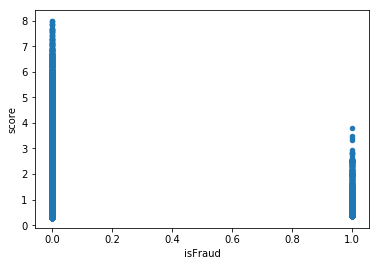

In [43]:
import matplotlib.pyplot as plt

score_vs_fraud.plot(kind='scatter',x='isFraud',y='score')